# 以Restnet進行 CIFAR-10分類 

## 1. 資料載入及前處理

#### 使用torchvision 載入資料

In [2]:
from torch import  nn
# import torch as t
from torch.nn import  functional as F
import torch
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 把Tensor轉成Image，方便視覺化

torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。

In [3]:
# 定義對資料的預處理 
# image=(image-mean)/std

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose(
    [transforms.ToTensor(),      # 轉為Tensor
     transforms.Normalize(mean,std)])   # 轉為常態分佈標準化

# 訓練集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, 
                                          num_workers=2, pin_memory=True, drop_last=True)

# 測試集
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2,
                                        pin_memory=True, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


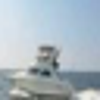

In [4]:
(data, label) = trainset[100]
print(classes[label])

#((data+1)/2) 是為了還原被標準化的資料
show((data+1)/2).resize((100,100))


#### 視覺化呈現資料

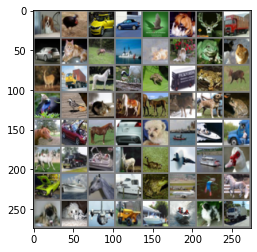

  dog  bird   car   car  bird   dog  deer truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

## 2. 定義神經網路(CNN)
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。

In [6]:
from torchvision import models
model = models.resnet18(num_classes=10)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 在GPU上訓練
将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。

如果我们有cuda可用的话，让我们首先定义第一个设备为可见cuda设备：

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# # model = Model(input_size, output_size)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model, device_ids = [0,1])

# model.to(device)
# # model.cuda(device)  # 將模型轉至GPU運算

## 运行模型
檢視输入和输出张量的大小

In [9]:
trainloader??

Type:        DataLoader
String form: <torch.utils.data.dataloader.DataLoader object at 0x7feb1bd437b8>
Length:      781
File:        /opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py
Source:     
class DataLoader(object):
    r"""
    Data loader. Combines a dataset and a sampler, and provides an iterable over
    the given dataset.

    The :class:`~torch.utils.data.DataLoader` supports both map-style and
    iterable-style datasets with single- or multi-process loading, customizing
    loading order and optional automatic batching (collation) and memory pinning.

    See :py:mod:`torch.utils.data` documentation page for more details.

    Arguments:
        dataset (Dataset): dataset from which to load the data.
        batch_size (int, optional): how many samples per batch to load
            (default: ``1``).
        shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: ``False``).
        sampler (Sampler, op

In [10]:
#  for _, data in enumerate(trainloader, 0):
#     input = data.to(device)
#     output = model(input)
#     print("Outside: input size", input.size(),
#           "output_size", output.size())

## 3. 定義損失函數和最佳化器(Loss 、Optimizer)
使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## 4. 訓練網路
重複執行以下流程：
- 輸入資料
- 正向傳播+反向傳播
- 更新參數

In [12]:
for epoch in range(10):  # loop over the dataset multiple times 僅訓練了2個epoch

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # i從0開始計數 
        
        # get the inputs 輸入資料
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # 把資料也送去GPU

        # zero the parameter gradients 梯度清空為0
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        # 更新參數
        optimizer.step()

        # print statistics
        running_loss += loss.item()  #如果是仅包含一个元素的tensor，可以使用.item()来得到对应的python数值
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 # 每2000回　loss 歸零重計

print('Finished Training')

[1,   200] loss: 0.171
[1,   400] loss: 0.140
[1,   600] loss: 0.124
[2,   200] loss: 0.102
[2,   400] loss: 0.101
[2,   600] loss: 0.095
[3,   200] loss: 0.081
[3,   400] loss: 0.080
[3,   600] loss: 0.080
[4,   200] loss: 0.065
[4,   400] loss: 0.069
[4,   600] loss: 0.068
[5,   200] loss: 0.056
[5,   400] loss: 0.059
[5,   600] loss: 0.058
[6,   200] loss: 0.045
[6,   400] loss: 0.049
[6,   600] loss: 0.049
[7,   200] loss: 0.036
[7,   400] loss: 0.041
[7,   600] loss: 0.041
[8,   200] loss: 0.028
[8,   400] loss: 0.032
[8,   600] loss: 0.035
[9,   200] loss: 0.023
[9,   400] loss: 0.026
[9,   600] loss: 0.029
[10,   200] loss: 0.018
[10,   400] loss: 0.021
[10,   600] loss: 0.023
Finished Training


儲存訓練完的模型


In [13]:
PATH = './cifar_restnet18.pth'
torch.save(model.state_dict(), PATH)

### 報錯
ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])<br>
原因 ：
>The error is most likely thrown during training and if the current batch only contains a single sample. 
 模型中用了batchnomolization，訓練中用batch訓練的時候當前batch恰好只含一個sample，而由於BatchNorm操作需要多於一個數據計算平均值，因此造成該錯誤<br>

對策：
1. 從dataset中删掉一個sample。
2. 在torch.utils.data.DataLoader類中或自己創建的繼承於DataLoader的類中設置參數drop_last=True，把不夠一個batch_size的數據丟棄
3. trainloader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=True, num_workers=2) 中把batch_size設為3的倍數

<br>
參考資料：<br>
https://www.cnblogs.com/zmbreathing/p/pyTorch_BN_error.html<br
https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/262 


## 5. 使用測試數據驗證結果

通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

載入保存的模型

In [14]:
restnet18 = models.resnet18(num_classes=10)
restnet18.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### 檢視模型判定的結果

In [15]:
outputs = restnet18(images)
outputs.shape

torch.Size([64, 10])

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

Predicted:    dog  bird   car   car  bird   dog  deer truck


神經網路在整個數據集上的表現

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # 計算圖片在每個類別上的分數
        outputs = restnet18(images)
        
        # 得分最高的那個類別
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = restnet18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 80 %
Accuracy of  bird : 70 %
Accuracy of   cat : 56 %
Accuracy of  deer : 76 %
Accuracy of   dog : 62 %
Accuracy of  frog : 76 %
Accuracy of horse : 76 %
Accuracy of  ship : 84 %
Accuracy of truck : 80 %
